In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import skfuzzy as fuzz

In [6]:
# Set data paths
DATA_DIR = "./data"
SOURCE_FILE = "fer2013.csv"

# Load data from local path
df = pd.read_csv(SOURCE_FILE)

# Ensure training directory exists
os.makedirs((DATA_DIR), exist_ok=True)

# We use for training and validation the "Training" and "PublicTest"
train_df = df[df['Usage']== 'Training'].copy()
vali_df = df[df['Usage'] == 'PublicTest'].copy()
test_df = df[df['Usage'] == 'PrivateTest'].copy() 

# Storing train and test data frames
train_df.to_csv("./data/fer2013_train.csv", encoding='utf-8', index=False)
vali_df.to_csv("./data/fer2013_validation.csv", encoding='utf-8', index=False)
test_df.to_csv("./data/fer2013_test.csv", encoding='utf-8', index=False)


Loaded FER-2013 with shape: (35887, 3)
Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64


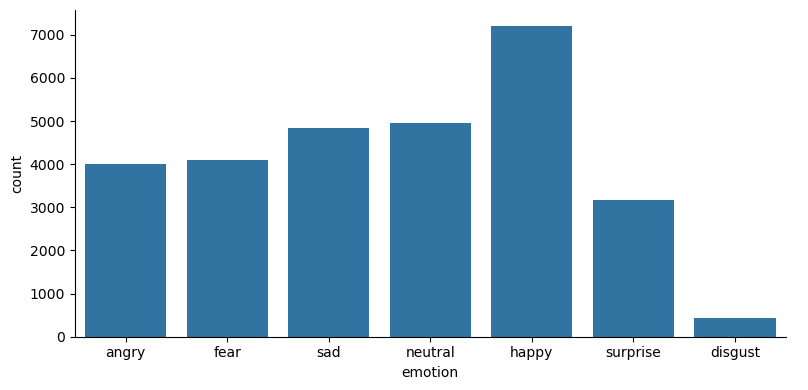

In [7]:
# Define label mapping
emotionDict = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral"
}
# Map integer labels to emotion names
sns.catplot(data=train_df.replace({'emotion': emotionDict}), kind='count', x='emotion', height=4, aspect=2)

#sns.countplot(x ='emotion', data = trai_df)
plt.show()

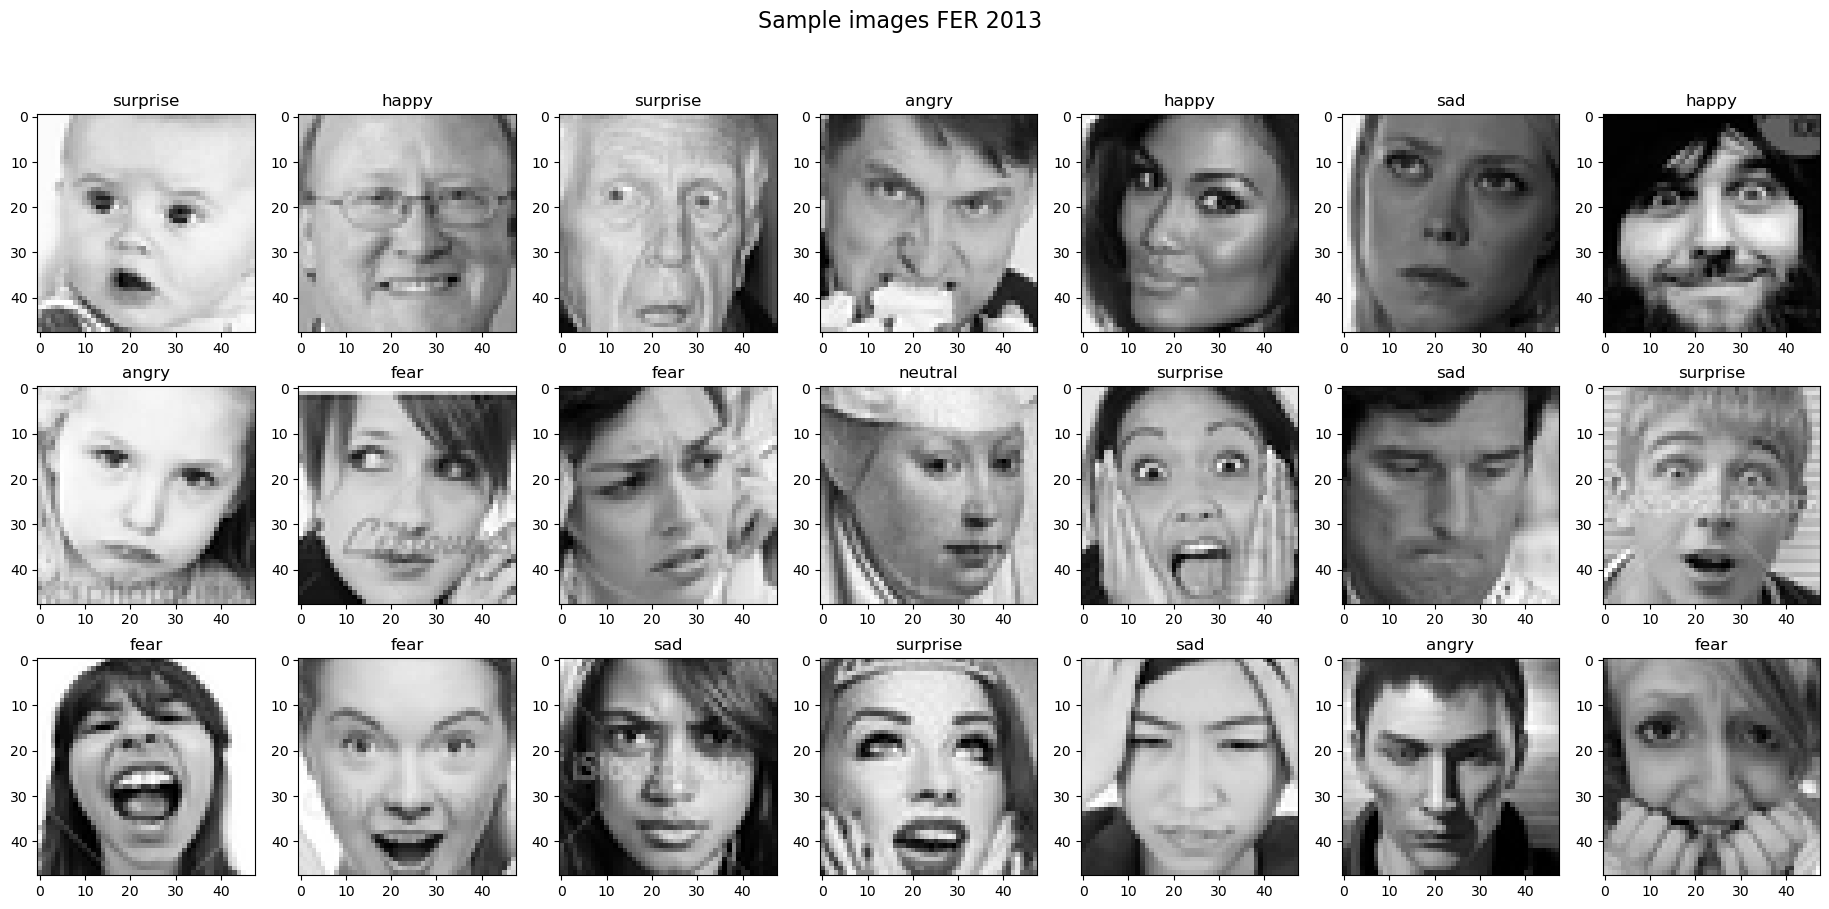

In [8]:
# Now making some plots
random_rows = df.sample(n=21, random_state=43)
imgs = [np.fromstring(pixels, sep=' ').reshape(48, 48) for pixels in random_rows['pixels']]
lbl =  random_rows['emotion'].values

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(23, 10))
fig.suptitle('Sample images FER 2013', fontsize=16)

# Loop through each subplot and customize
for i in range(7):
    for j in range(3):
        ax = axes[j, i]
        ax.imshow(imgs[j*7+i], cmap="gray") 
        ax.set_title('%s'%(emotionDict[lbl[j*7+i]]))
        #ax.grid(True)
plt.show()

In [9]:
# Create function for converting pixels string to 48x48 numpy array
def pixels_to_array(pixels_str):
   """
    Convert pixel string into a 48x48 NumPy array.
    Input:
    - pixels_str = string of 2304 grayscale pixel values (e.g., "70 80 82 ...")
    Output:
    - NumPy array of shape (48, 48) with dtype uint8 representing the image
    """
   return np.fromstring(pixels_str, sep=" ", dtype=np.uint8).reshape(48, 48)

In [10]:
def load_split(path):
    """Load a pre-split FER-2013 CSV file and return normalized image and label arrays.
    Input:
    - path = path to CSV file (e.g., './data/fer2013_train.csv')
    Output:
    - X = NumPy array of shape (N, 48, 48) with normalized pixel values in [0, 1]
    - y = NumPy array of shape (N,) with integer emotion labels (0–6)
    """
    # read CSV file and convert pixels to arrays and labels to integers
    df = pd.read_csv(path)
    X = np.stack(df["pixels"].apply(pixels_to_array))
    y = df["emotion"].to_numpy(dtype=np.int64)

    # Normalize pixel values to [0, 1]
    X = X.astype(np.float32) / 255.0 
    print(f"{path}: X={X.shape}, y={y.shape}")
    return X, y


# Load each split
X_train, y_train = load_split("./data/fer2013_train.csv")
X_val, y_val     = load_split("./data/fer2013_validation.csv")
X_test, y_test   = load_split("./data/fer2013_test.csv")

./data/fer2013_train.csv: X=(28709, 48, 48), y=(28709,)
./data/fer2013_validation.csv: X=(3589, 48, 48), y=(3589,)
./data/fer2013_test.csv: X=(3589, 48, 48), y=(3589,)


In [11]:
# DEBUG, i think all model support "weighted" as class weight option
# So this might be redundant

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {emotionDict[c]: w for c, w in zip(classes, class_weights)}
print("Class weights (use for sklearn models):")
print(class_weights_dict)

Class weights (use for sklearn models):
{'angry': np.float64(1.0266046844269623), 'disgust': np.float64(9.406618610747051), 'fear': np.float64(1.0010460615781582), 'happy': np.float64(0.5684387684387684), 'sad': np.float64(0.8491274770777877), 'surprise': np.float64(1.293372978330405), 'neutral': np.float64(0.8260394187886635)}


In [13]:
def augment_flip(X, y):
    Xf = np.flip(X, axis=2)  # flip horizontally
    return np.concatenate([X, Xf]), np.concatenate([y, y])

X_train_aug, y_train_aug = augment_flip(X_train, y_train)

In [14]:
def extract_features(X, params=None):
    """
    Extract multiple types of features (raw, HOG, LBP) from grayscale images.

    Input:
    - X: NumPy array of shape (N, 48, 48)
    - params: dict containing 'hog' and 'lbp' parameter sets

    Output:
    - X_raw: flattened & normalized raw pixel features (N, 2304)
    - X_hog: HOG feature vectors (N, ?)
    - X_lbp: normalized LBP histograms (N, bins)
    """
    # --- Raw pixel features ---
    X_raw = X.reshape(len(X), -1).astype(np.float32) / 255.0

    # --- HOG features ---
    hog_params = params["hog"]
    X_hog = np.asarray([hog(img, **hog_params) for img in X], dtype=np.float32)

    # --- LBP features ---
    lbp_params = params["lbp"]
    P, R, method = lbp_params["P"], lbp_params["R"], lbp_params["method"]
    n_bins = P + 2 if method == "uniform" else int(X.max()) + 1
    X_lbp = []
    for img in X:
        lbp = local_binary_pattern(img, P=P, R=R, method=method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
        hist = hist.astype(np.float32)
        hist /= (hist.sum() + 1e-8)
        X_lbp.append(hist)
    X_lbp = np.asarray(X_lbp, dtype=np.float32)

    print(f"Extracted: RAW={X_raw.shape}, HOG={X_hog.shape}, LBP={X_lbp.shape}")
    return X_raw, X_hog, X_lbp

In [15]:
FEATURE_PARAMS = {
    "hog": {"orientations": 9, "pixels_per_cell": (8, 8), "cells_per_block": (2, 2),
        "block_norm": "L2-Hys", "transform_sqrt": True, "feature_vector": True},
    "lbp": {"P": 8, "R": 1.0, "method": "uniform"}}


# Build features for all splits
X_train_raw, X_train_hog, X_train_lbp = extract_features(X_train, FEATURE_PARAMS)
X_val_raw,   X_val_hog,   X_val_lbp  = extract_features(X_val, FEATURE_PARAMS)
X_test_raw,  X_test_hog,  X_test_lbp = extract_features(X_test, FEATURE_PARAMS)


c:\ProgramData\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracted: RAW=(28709, 2304), HOG=(28709, 900), LBP=(28709, 10)
Extracted: RAW=(3589, 2304), HOG=(3589, 900), LBP=(3589, 10)
Extracted: RAW=(3589, 2304), HOG=(3589, 900), LBP=(3589, 10)


In [16]:
# Train scalers on training data
scaler_raw = StandardScaler().fit(X_train_raw)
scaler_hog = StandardScaler().fit(X_train_hog)
scaler_lbp = StandardScaler().fit(X_train_lbp)

# Apply scalers to all features
X_train_raw = scaler_raw.transform(X_train_raw)
X_val_raw   = scaler_raw.transform(X_val_raw)
X_test_raw  = scaler_raw.transform(X_test_raw)

X_train_hog = scaler_hog.transform(X_train_hog)
X_val_hog   = scaler_hog.transform(X_val_hog)
X_test_hog  = scaler_hog.transform(X_test_hog)

X_train_lbp = scaler_lbp.transform(X_train_lbp)
X_val_lbp   = scaler_lbp.transform(X_val_lbp)
X_test_lbp  = scaler_lbp.transform(X_test_lbp)


In [17]:
# PCA (fit ONLY on train, apply to all)

# Amount of variance to keep, 0.95 = 95% variance explained
PCA_N_COMPONENTS = 0.95

# PCA for RAW
pca_raw = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
X_train_raw = pca_raw.fit_transform(X_train_raw)
X_val_raw   = pca_raw.transform(X_val_raw)
X_test_raw  = pca_raw.transform(X_test_raw)
print(f"RAW → {pca_raw.n_components_} components "
      f"({pca_raw.explained_variance_ratio_.sum():.2%} variance)")

# PCA for HOG
pca_hog = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
X_train_hog = pca_hog.fit_transform(X_train_hog)
X_val_hog   = pca_hog.transform(X_val_hog)
X_test_hog  = pca_hog.transform(X_test_hog)
print(f"HOG → {pca_hog.n_components_} components "
      f"({pca_hog.explained_variance_ratio_.sum():.2%} variance)")

# PCA for LBP
pca_lbp = PCA(n_components=PCA_N_COMPONENTS, random_state=42)
X_train_lbp = pca_lbp.fit_transform(X_train_lbp)
X_val_lbp   = pca_lbp.transform(X_val_lbp)
X_test_lbp  = pca_lbp.transform(X_test_lbp)
print(f"LBP → {pca_lbp.n_components_} components "
      f"({pca_lbp.explained_variance_ratio_.sum():.2%} variance)")

RAW → 269 components (95.01% variance)
HOG → 277 components (95.03% variance)
LBP → 7 components (97.03% variance)


In [18]:
# Now that we have all features, and scaled them appropriately,
# we can combine them into a single feature set for each split
X_train_pca = np.hstack([X_train_raw, X_train_hog, X_train_lbp])
X_val_pca   = np.hstack([X_val_raw, X_val_hog, X_val_lbp])
X_test_pca  = np.hstack([X_test_raw, X_test_hog, X_test_lbp])

print("Combined feature shapes:")
print("  Train:", X_train_pca.shape)
print("  Val:", X_val_pca.shape)
print("  Test:", X_test_pca.shape)

Combined feature shapes:
  Train: (28709, 553)
  Val: (3589, 553)
  Test: (3589, 553)


In [ ]:
def print_scores(name, y_true, y_pred, labels=None):
    """ 
    Evaluate and visualize model performance.

    Input:
    - name (str): Name of the model (for printing)
    - y_true (array-like): True class labels
    - y_pred (array-like): Predicted class labels
    - labels (list, optional): Class label names for confusion matrix

    Output:
    - Prints Accuracy, Cohen’s Kappa, and F1-score
    - Displays confusion matrix heatmap
    """
    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    # Print numeric results
    print(f"Total {name} evaluation:")
    print(f"Accuracy:       {acc:.3f}")
    print(f"Cohen’s Kappa:  {kappa:.3f}")
    print(f"Weighted F1:    {f1:.3f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels, digits=3))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    

In [ ]:
# For quick grid search, we can use a smaller subset of the training data. 
# Since SVM scales O(n^2) low n reduces computation time significantly.
# We use stratified sampling to keep class distribution similar.
X_sub, _, y_sub, _ = train_test_split(
    X_train_pca, y_train,
    test_size=0.9,             # keep only 10% of data for grid search
    stratify=y_train,          # keep class distribution
    random_state=42
    )

# Models

In [43]:
# Define parameter grid for SVC
param_grid = {
    "kernel": ["rbf", "poly", "sigmoid"],   # try different kernel shapes
    "C": [1, 5, 10, 25],     # regularization strengths
    "gamma": ["scale", "auto", 1, 0.1, 0.01],  # kernel coefficient
    "degree": [2, 3,4]                    # used only for 'poly' kernel
    }

# Initialize SVC model for grid search
svm = SVC(class_weight="balanced", random_state=42)

# Run grid search
grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring="f1_weighted",      # Use weighted F1-score for evaluation
    cv=3,                       # 3-fold CV for speed
    n_jobs=-1,                  # use all CPU cores
    verbose=2
)

grid.fit(X_sub, y_sub)

print("\nBest parameters found:")
print(grid.best_params_)


Fitting 3 folds for each of 180 candidates, totalling 540 fits

Best parameters found:
{'C': 5, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
best_params = grid.best_params_

svm_final = SVC(
    **best_params,
    class_weight="balanced",
    random_state=42
)
print("\nTraining final SVM on full training data...")
svm_final.fit(X_train_pca, y_train)

# Validate
y_val_pred = svm_final.predict(X_val_pca)
print_scores("SVM Final", y_val, y_val_pred, labels=[label_map[c] for c in classes])


Training final SVM on full training data...
Validation accuracy: 0.5625522429646141
              precision    recall  f1-score   support

           0      0.419     0.463     0.439       467
           1      0.968     0.536     0.690        56
           2      0.451     0.413     0.431       496
           3      0.710     0.743     0.726       895
           4      0.463     0.444     0.453       653
           5      0.760     0.718     0.739       415
           6      0.499     0.519     0.509       607

    accuracy                          0.563      3589
   macro avg      0.610     0.548     0.570      3589
weighted avg      0.565     0.563     0.562      3589



In [26]:
# Parameter grid to test with grid search
param_grid = {
    "hidden_layer_sizes": [(128,), (256,), (256,128), (512,256)],
    "activation": ["relu", "tanh"],
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [0.001, 0.0005],
    "batch_size": [128, 256],
}

# Initialize MLP model for grid search
mlp = MLPClassifier(
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# Run grid search for MLP
grid_mlp = GridSearchCV(
    mlp,
    param_grid,
    scoring="f1_weighted",     # Use weighted F1-score for evaluation, Since data is imbalanced
    cv=3,                      # 3-fold CV for speed
    n_jobs=-1,
    verbose=2
)
# Train on subset for speed
grid_mlp.fit(X_sub, y_sub)

print("\n✅ MLP GridSearch complete!")
print("Best parameters:", grid_mlp.best_params_)
print(f"Best CV F1 (weighted): {grid_mlp.best_score_:.3f}")

Fitting 3 folds for each of 96 candidates, totalling 288 fits

✅ MLP GridSearch complete!
Best parameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 128, 'hidden_layer_sizes': (512, 256), 'learning_rate_init': 0.001}
Best CV F1 (weighted): 0.349


Total Best MLP evaluation:
Accuracy:       0.520
Cohen’s Kappa:  0.420
Weighted F1:    0.519

Classification Report:
              precision    recall  f1-score   support

       angry      0.380     0.437     0.406       467
     disgust      0.605     0.464     0.525        56
        fear      0.366     0.365     0.366       496
       happy      0.686     0.709     0.698       895
         sad      0.456     0.397     0.424       653
    surprise      0.661     0.689     0.675       415
     neutral      0.469     0.455     0.462       607

    accuracy                          0.520      3589
   macro avg      0.518     0.502     0.508      3589
weighted avg      0.519     0.520     0.519      3589



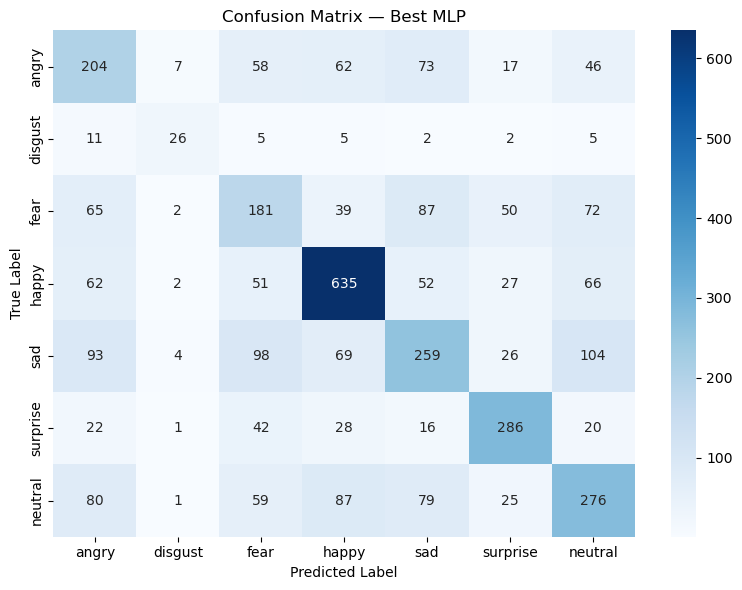

In [31]:
# Train final model on full PCA data
mlp_best = MLPClassifier(
    **grid_mlp.best_params_,
    max_iter=150,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)
mlp_best.fit(X_train_pca, y_train)
y_val_pred_mlp = mlp_best.predict(X_val_pca)
print_scores("Best MLP", y_val, y_val_pred_mlp, labels=[label_map[c] for c in classes])

In [ ]:
# Parameter grid to test with grid search
param_grid = {
    "n_estimators": [300, 500, 1000],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

# Initialize Random Forest model for grid search
rf = RandomForestClassifier(
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

# Run grid search for Random Forest
grid_rf = GridSearchCV(
    rf,
    param_grid,
    scoring="f1_weighted",     # Use weighted F1-score for evaluation
    cv=2,                      # 2-fold CV for speed
    n_jobs=-1,
    verbose=2
)

# Train on subset for speed
grid_rf.fit(X_sub, y_sub)

print("\n Random Forest GridSearch complete!")
print("Best parameters:", grid_rf.best_params_)
print(f"Best CV F1 (weighted): {grid_rf.best_score_:.3f}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits

✅ Random Forest GridSearch complete!
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Best CV F1 (weighted): 0.330


Total Best Random Forest evaluation:
Accuracy:       0.454
Cohen’s Kappa:  0.334
Weighted F1:    0.435

Classification Report:
              precision    recall  f1-score   support

       angry      0.328     0.310     0.319       467
     disgust      1.000     0.286     0.444        56
        fear      0.457     0.169     0.247       496
       happy      0.547     0.706     0.616       895
         sad      0.378     0.366     0.372       653
    surprise      0.475     0.701     0.566       415
     neutral      0.409     0.367     0.387       607

    accuracy                          0.454      3589
   macro avg      0.513     0.415     0.422      3589
weighted avg      0.451     0.454     0.435      3589



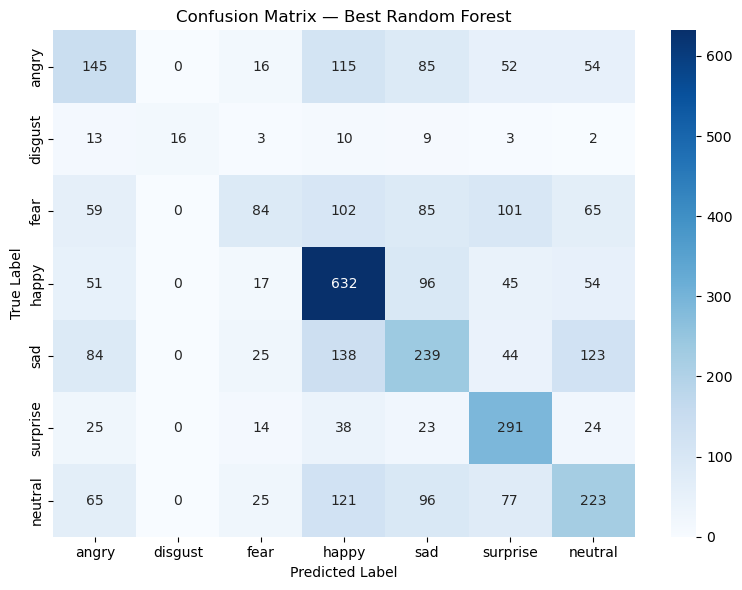

In [33]:
# Train final model on full PCA data
rf_best = RandomForestClassifier(
    **grid_rf.best_params_,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf_best.fit(X_train_pca, y_train)
y_val_pred_rf = rf_best.predict(X_val_pca)
print_scores("Best Random Forest", y_val, y_val_pred_rf, labels=[label_map[c] for c in classes])

Fuzzy Partition Coefficient (FPC): 0.143
Cluster → Emotion mapping:
  Cluster 0: happy
  Cluster 1: angry
  Cluster 2: angry
  Cluster 3: neutral
  Cluster 4: happy
  Cluster 5: happy
  Cluster 6: happy
Total Fuzzy Classifier evaluation:
Accuracy:       0.245
Cohen’s Kappa:  0.000
Weighted F1:    0.096

Classification Report:
              precision    recall  f1-score   support

       angry      0.000     0.000     0.000       491
     disgust      0.000     0.000     0.000        55
        fear      0.000     0.000     0.000       528
       happy      0.245     1.000     0.394       879
         sad      0.000     0.000     0.000       594
    surprise      0.000     0.000     0.000       416
     neutral      0.000     0.000     0.000       626

    accuracy                          0.245      3589
   macro avg      0.035     0.143     0.056      3589
weighted avg      0.060     0.245     0.096      3589



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


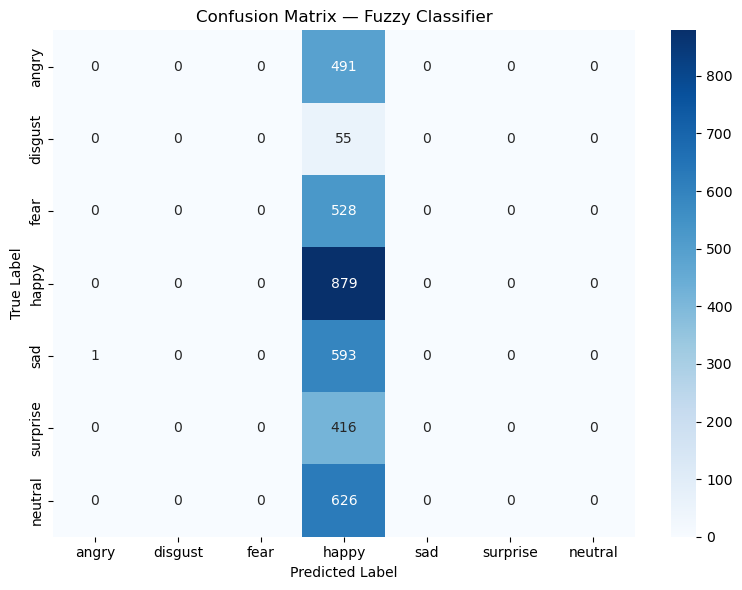

In [ ]:

X_train_T = X_train_pca.T
X_test_T  = X_test_pca.T

n_clusters = 7     # number of emotions
m = 2.0            # fuzziness coefficient

# Train fuzzy clusters on training data ---
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_train_T,
    c=n_clusters,
    m=m,
    error=0.005,
    maxiter=1000,
    init=None,
    seed=42
)

print(f"Fuzzy Partition Coefficient (FPC): {fpc:.3f}")

# Assign each training sample to its strongest cluster ---
train_fcm_labels = np.argmax(u, axis=0)

# Map each cluster → most common true label in that cluster ---
labels_map_fcm = {}
for cluster_id in range(n_clusters):
    mask = (train_fcm_labels == cluster_id)
    if np.any(mask):
        labels_map_fcm[cluster_id] = pd.Series(y_train[mask]).mode()[0]

print("Cluster → Emotion mapping:")
for c, label in labels_map_fcm.items():
    print(f"  Cluster {c}: {label_map[label]}")

# Predict on test data using learned fuzzy centers ---
u_test, u0, d, jm, p, fpc_test = fuzz.cluster.cmeans_predict(
    X_test_T, cntr, m=m, error=0.005, maxiter=1000
)

# Hard cluster assignment for test samples
test_fcm_labels = np.argmax(u_test, axis=0)

# Convert cluster IDs → predicted emotion labels
y_test_pred_fuzzy = np.array([labels_map_fcm[c] for c in test_fcm_labels])

print_scores(
    "Fuzzy Classifier",
    y_test,
    y_test_pred_fuzzy,
    labels=list(label_map.values())
)

